stop here 

In [48]:
#!/usr/bin/env python3
"""
Condition-aware CellPhoneDB v5 pipeline + official ktplotspy plots + custom grouped injured-subtype plots.

Requirements:
 - Python environment with: cellphonedb (v5), ktplotspy, scanpy, pandas, numpy, matplotlib, seaborn
 - The script loads the AnnData directly, filters for Hotspots (score > 1.5), 
   generates the input files, and runs the analysis.
"""

import os
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

# ---- cellphonedb / ktplotspy imports ----
from cellphonedb.src.core.methods import cpdb_statistical_analysis_method

# ktplotspy exposes convenience plotting functions in some versions.
try:
    from ktplotspy import ktplotspy as kt
    kt_available = True
except Exception:
    try:
        from ktplotspy import CPDBPlot
        kt_available = True
    except Exception:
        kt_available = False

if not kt_available:
    print("WARNING: ktplotspy is not importable. Official dotplots will be skipped.\n", file=sys.stderr)

# -----------------------
# Configuration & Paths
# -----------------------
# Input AnnData (Must contain the 'tcm_score_hotspot' column)
AD_PATH = "../../data/Kidney_ST/Kidney_CosMx_Hotspot_Scored.h5ad"

# Output Directory
BASE_DIR = "../../analysis/06_CellPhoneDB_Hotspots_Direct"
CPDB_OUTPUT_ROOT = os.path.join(BASE_DIR, "cellphonedb_results")

# Database Path
CPDB_DB_PATH = "/mnt/home3/miska/nm667/scratch/inProgress/dev/scripts/Kidney_ST/cpdb_database/cellphonedb.zip"

# Columns & Thresholds
CELL_TYPE_COL = 'cellType_CosMx_2'
CONDITION_COL = 'type'
SCORE_COL = 'tcm_score_hotspot'
THRESHOLD = 1.5

os.makedirs(CPDB_OUTPUT_ROOT, exist_ok=True)

# -----------------------
# Helper utilities
# -----------------------


def prepare_cpdb_inputs_from_adata(adata_path, output_dir):
    """
    Loads AnnData, filters for hotspots, and writes global meta/counts files.
    Returns: (meta_df, counts_file_path)
    """
    print(f"Loading AnnData from {adata_path}...")
    if not os.path.exists(adata_path):
        raise FileNotFoundError(f"AnnData file not found: {adata_path}")

    adata = sc.read_h5ad(adata_path)

    if SCORE_COL not in adata.obs.columns:
        raise ValueError(f"Score column '{SCORE_COL}' not found in AnnData.")

    # Filter for Hotspots
    print(f"Filtering for hotspots ({SCORE_COL} >= {THRESHOLD})...")
    hotspot_adata = adata[adata.obs[SCORE_COL] >= THRESHOLD].copy()
    print(
        f"  -> Retained {hotspot_adata.n_obs} hotspot cells out of {adata.n_obs}.")

    if hotspot_adata.n_obs == 0:
        raise ValueError(
            "No cells met the hotspot threshold. Check your score column.")

    # Prepare Meta DataFrame
    # Index = Cell ID, Columns = ['cell_type', 'condition', 'orig_label']
    meta = pd.DataFrame(index=hotspot_adata.obs_names)
    meta["cell_type"] = hotspot_adata.obs[CELL_TYPE_COL]  # Required for CPDB
    meta["condition"] = hotspot_adata.obs[CONDITION_COL]
    meta["orig_label"] = hotspot_adata.obs[CELL_TYPE_COL]  # For plotting later

    # Prepare Counts DataFrame
    # Prefer raw counts if available
    if hotspot_adata.raw is not None:
        print("  -> Using .raw.X for counts...")
        counts_mat = hotspot_adata.raw.X.T
        genes = hotspot_adata.raw.var_names
    else:
        print("  -> Using .X for counts...")
        counts_mat = hotspot_adata.X.T
        genes = hotspot_adata.var_names

    if hasattr(counts_mat, 'toarray'):
        counts_mat = counts_mat.toarray()

    counts_df = pd.DataFrame(data=counts_mat, index=genes,
                             columns=hotspot_adata.obs_names)

    # Write to disk (CellPhoneDB requires file paths)
    meta_path = os.path.join(output_dir, "meta_hotspot_all.txt")
    counts_path = os.path.join(output_dir, "counts_hotspot_all.txt")

    print(f"Writing temporary files to {output_dir}...")
    meta.to_csv(meta_path, sep="\t")
    counts_df.to_csv(counts_path, sep="\t")

    return meta, counts_path, counts_df


def run_cpdb_for_subset(meta_file, counts_file, db_zip, out_dir, threads=8):
    """
    Run cpdb_statistical_analysis_method.call for given meta file.
    """
    os.makedirs(out_dir, exist_ok=True)
    results = cpdb_statistical_analysis_method.call(
        cpdb_file_path=db_zip,
        meta_file_path=meta_file,
        counts_file_path=counts_file,
        counts_data='hgnc_symbol',
        score_interactions=True,
        threshold=0.1,
        output_path=out_dir,
        threads=threads
    )
    return results


def cpdb_dotplot_with_ktplots(means_path, pvalues_path, sig_means_path, meta_path, out_dir, pair=None, top_n=30):
    """
    Use ktplotspy to produce a CPDB-style dotplot and heatmap.
    """
    os.makedirs(out_dir, exist_ok=True)
    if "kt" in globals() and hasattr(kt, "plot_cpdb_dotplot"):
        kwargs = dict(
            means=pd.read_csv(means_path, sep="\t"),
            pvalues=pd.read_csv(pvalues_path, sep="\t"),
            significant_means=pd.read_csv(sig_means_path, sep="\t"),
            interaction_group=pair if pair is not None else None,
            top_n_interactions=top_n,
            figsize=(10, max(6, top_n//2)),
            show=False
        )
        try:
            fig = kt.plot_cpdb_dotplot(**kwargs)
            fig.savefig(os.path.join(out_dir, "ktplotspy_dotplot.png"),
                        dpi=300, bbox_inches="tight")
            plt.close(fig)
        except Exception as e:
            print(f"ktplotspy dotplot failed: {e}")
        return


def compute_limiting_pct_from_counts(counts_df, meta_df_cond, ligand, receptor, sender_orig_label, sender_group_label="Injured_Sender", receiver_group_label="Immune_Receiver"):
    if ligand not in counts_df.index or receptor not in counts_df.index:
        return 0.0

    # Handle logic where sender_group_label might be the same as sender_orig_label (direct mapping)
    if sender_group_label == sender_orig_label:
        sender_cells = meta_df_cond[meta_df_cond["cell_type"]
                                    == sender_group_label].index.tolist()
    else:
        # Complex mapping (e.g. Group "Injured" contains "iPT_0")
        sender_cells = meta_df_cond[(meta_df_cond["cell_type"] == sender_group_label) & (
            meta_df_cond["orig_label"] == sender_orig_label)].index.tolist()

    receiver_cells = meta_df_cond[meta_df_cond["cell_type"]
                                  == receiver_group_label].index.tolist()

    if len(sender_cells) == 0 or len(receiver_cells) == 0:
        return 0.0

    pct_lig = (counts_df.loc[ligand, sender_cells] >
               0).sum() / max(1, len(sender_cells)) * 100.0
    pct_rec = (counts_df.loc[receptor, receiver_cells]
               > 0).sum() / max(1, len(receiver_cells)) * 100.0

    return min(pct_lig, pct_rec)


def find_latest_file(directory, pattern):
    """Finds the latest file matching a pattern (e.g., pvalues_*.txt) in a directory."""
    files = glob.glob(os.path.join(directory, pattern))
    if not files:
        return None
    return max(files, key=os.path.getctime)


def plot_comparison_dotplot(conditions, output_root, meta_all, counts_df, top_n=30):
    """
    Generates a Healthy vs. Disease comparison dot plot for 'Injured -> Immune' interactions.
    """
    print(
        f"\n--- Generating Healthy vs. Disease Comparison Plot (Top {top_n}) ---")

    data_rows = []

    # Define interesting cell pairs (Injured -> Immune)
    keywords_sender = ["Injured", "iPT", "TAL"]
    keywords_receiver = ["Immune", "Macrophage", "T cell", "Neutrophil"]

    for cond in conditions:
        cond_dir = os.path.join(output_root, cond)

        # Find latest files
        p_file = find_latest_file(
            cond_dir, "statistical_analysis_pvalues_*.txt")
        m_file = find_latest_file(cond_dir, "statistical_analysis_means_*.txt")

        if not p_file or not m_file:
            print(f"Skipping {cond}: Missing CPDB output files.")
            continue

        pvals = pd.read_csv(p_file, sep="\t")
        means = pd.read_csv(m_file, sep="\t")

        # Identify relevant columns (Cell Pairs)
        relevant_cols = []
        for col in pvals.columns[11:]:  # Skip first 11 metadata columns
            if "|" in col:
                c1, c2 = col.split("|")
                # check if c1 is injured-like AND c2 is immune-like
                is_sender_inj = any(k in c1 for k in keywords_sender)
                is_rec_imm = any(k in c2 for k in keywords_receiver)

                if is_sender_inj and is_rec_imm:
                    relevant_cols.append(col)

        if not relevant_cols:
            print(f"No 'Injured -> Immune' pairs found in {cond} results.")
            continue

        # Extract data for these columns
        meta_cond = meta_all[meta_all["condition"] == cond]

        for col in relevant_cols:
            sender_type, receiver_type = col.split("|")

            # Filter for significant interactions (p < 0.05)
            sig_mask = pvals[col] < 0.05
            sig_interactions = pvals[sig_mask]

            # Limit to top N by p-value
            top_df = sig_interactions.sort_values(col).head(top_n)

            for _, row in top_df.iterrows():
                interaction = row['interacting_pair']
                pval = row[col]

                # Get mean
                mean_val = means.loc[means['interacting_pair']
                                     == interaction, col].values[0]

                # Calculate Pct manually
                if "_" in interaction:
                    ligand, receptor = interaction.split("_", 1)
                else:
                    ligand = interaction
                    receptor = interaction

                pct = compute_limiting_pct_from_counts(
                    counts_df, meta_cond, ligand, receptor,
                    sender_orig_label=sender_type,
                    sender_group_label=sender_type,
                    receiver_group_label=receiver_type
                )

                data_rows.append({
                    "Condition": cond,
                    "Cell_Pair": f"{sender_type} -> {receiver_type}",
                    "Interaction": interaction,
                    "P-value": pval,
                    "Mean": mean_val,
                    "Pct": pct
                })

    if not data_rows:
        print("No significant data found to plot.")
        return

    df = pd.DataFrame(data_rows)

    # Save plotting data to CSV
    csv_out_path = os.path.join(
        output_root, "Comparison_Healthy_vs_Disease_PlotData.csv")
    df.to_csv(csv_out_path, index=False)
    print(f"Plotting data saved to CSV: {csv_out_path}")

    # --- PLOTTING ---
    # Rank interactions by min p-value across whole dataset
    top_interactions = df.groupby("Interaction")[
        "P-value"].min().sort_values().head(top_n).index
    plot_df = df[df["Interaction"].isin(top_interactions)].copy()

    # Create star label
    def get_star(p):
        if p < 0.001:
            return "***"
        if p < 0.01:
            return "**"
        if p < 0.05:
            return "*"
        return ""

    plot_df["Significance"] = plot_df["P-value"].apply(get_star)
    plot_df["Y_Label"] = plot_df["Interaction"] + \
        " (" + plot_df["Cell_Pair"] + ")"

    y_order = sorted(plot_df["Y_Label"].unique())

    # Increase width (10) and reduce height factor (0.35)
    plt.figure(figsize=(10, len(y_order) * 0.35 + 2))
    sns.set_style("whitegrid")

    # Scatter plot
    ax = sns.scatterplot(
        data=plot_df,
        x="Condition",
        y="Y_Label",
        size="Pct",
        hue="Mean",
        sizes=(50, 500),
        palette="RdBu_r",
        edgecolor="black",
        linewidth=1
    )

    # Add stars
    for _, row in plot_df.iterrows():
        if row["Significance"]:
            ax.text(
                row["Condition"],
                row["Y_Label"],
                row["Significance"],
                color='black',
                ha='center',
                va='center',
                fontsize=10,
                fontweight='bold'
            )

    # Add margins to prevent clipping
    plt.margins(x=0.15, y=0.05)

    # Legends & Layout
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left',
               borderaxespad=0, title="Mean Exp & % Cells")
    plt.title(
        f"Top {top_n} Interactions (Healthy vs Disease)\nInjured -> Immune Hotspots")
    plt.xlabel("")
    plt.ylabel("")

    # Add caption for stars
    plt.figtext(0.99, 0.01, "* p<0.05, ** p<0.01, *** p<0.001",
                ha="right", fontsize=8, style='italic')

    plt.tight_layout()

    # Save as PNG and PDF
    png_path = os.path.join(
        output_root, "Comparison_Healthy_vs_Disease_Dotplot.png")
    pdf_path = os.path.join(
        output_root, "Comparison_Healthy_vs_Disease_Dotplot.pdf")
    plt.savefig(png_path, bbox_inches='tight', dpi=300)
    plt.savefig(pdf_path, bbox_inches='tight')
    plt.close()
    print(f"Comparison plot saved: {png_path} and {pdf_path}")


# -----------------------
# Main pipeline
# -----------------------

def main():
    # 1. Load AnnData, Filter Hotspots, Generate Inputs
    # We need the meta/counts to do the plotting calculations even if we skip CPDB analysis
    meta_all, counts_path, counts_df = prepare_cpdb_inputs_from_adata(
        AD_PATH, CPDB_OUTPUT_ROOT)

    # 2. Iterate Conditions
    conditions = sorted(meta_all["condition"].unique().astype(str).tolist())
    conditions = [c for c in conditions if c.lower() not in [
        'nan', 'unknown']]  # clean list

    print("\nFound conditions:", conditions)

    for cond in conditions:
        print(f"\n--- Processing condition: {cond} ---")
        meta_cond = meta_all[meta_all["condition"] == cond]

        if meta_cond.shape[0] < 5:
            print(f"Skipping {cond}: Too few cells ({meta_cond.shape[0]}).")
            continue

        out_cond_dir = os.path.join(CPDB_OUTPUT_ROOT, cond)

        # --- CELLPHONEDB EXECUTION STEP (SKIPPED) ---
        print("Skipping CellPhoneDB analysis execution (assuming outputs exist)...")
        # results = run_cpdb_for_subset(meta_cond_path, counts_path, CPDB_DB_PATH, out_cond_dir)
        # --------------------------------------------

        # Plots (Per Condition)
        means_path = os.path.join(
            out_cond_dir, "means.txt")  # Standard name check
        if not os.path.exists(means_path):
            means_path = find_latest_file(
                out_cond_dir, "statistical_analysis_means_*.txt")

        if not means_path or not os.path.exists(means_path):
            print(f"WARNING: Output files not found for {cond}. Cannot plot.")
            continue

        if "kt" in globals() and means_path:
            pvals_path = find_latest_file(
                out_cond_dir, "statistical_analysis_pvalues_*.txt")
            sig_means_path = find_latest_file(
                out_cond_dir, "statistical_analysis_significant_means_*.txt")
            meta_cond_path = os.path.join(CPDB_OUTPUT_ROOT, f"meta_{cond}.txt")

            if pvals_path and sig_means_path and os.path.exists(meta_cond_path):
                cpdb_dotplot_with_ktplots(means_path, pvals_path, sig_means_path, meta_cond_path,
                                          out_cond_dir, pair="Injured_Sender|Immune_Receiver")

    # 3. Generate COMPARISON Plot (Healthy vs Disease)
    if len(conditions) > 1:
        try:
            plot_comparison_dotplot(
                conditions, CPDB_OUTPUT_ROOT, meta_all, counts_df, top_n=30)
        except Exception as e:
            print(f"Comparison plot failed: {e}")
            import traceback
            traceback.print_exc()

    print("\nALL DONE. Results saved under:", CPDB_OUTPUT_ROOT)


if __name__ == "__main__":
    main()


Loading AnnData from ../../data/Kidney_ST/Kidney_CosMx_Hotspot_Scored.h5ad...


Filtering for hotspots (tcm_score_hotspot >= 1.5)...
  -> Retained 61664 hotspot cells out of 83204.
  -> Using .X for counts...
Writing temporary files to ../../analysis/06_CellPhoneDB_Hotspots_Direct/cellphonedb_results...

Found conditions: ['Disease', 'Healthy']

--- Processing condition: Disease ---
Skipping CellPhoneDB analysis execution (assuming outputs exist)...

--- Processing condition: Healthy ---
Skipping CellPhoneDB analysis execution (assuming outputs exist)...

--- Generating Healthy vs. Disease Comparison Plot (Top 30) ---
Plotting data saved to CSV: ../../analysis/06_CellPhoneDB_Hotspots_Direct/cellphonedb_results/Comparison_Healthy_vs_Disease_PlotData.csv
Comparison plot saved: ../../analysis/06_CellPhoneDB_Hotspots_Direct/cellphonedb_results/Comparison_Healthy_vs_Disease_Dotplot.png and ../../analysis/06_CellPhoneDB_Hotspots_Direct/cellphonedb_results/Comparison_Healthy_vs_Disease_Dotplot.pdf

ALL DONE. Results saved under: ../../analysis/06_CellPhoneDB_Hotspots_Dir

Loading data from ../../analysis/06_CellPhoneDB_Hotspots_Direct/cellphonedb_results/Comparison_Healthy_vs_Disease_PlotData.csv...
Plots saved to:
  - ../../analysis/06_CellPhoneDB_Hotspots_Direct/Comparison_DotPlot.png
  - ../../analysis/06_CellPhoneDB_Hotspots_Direct/Comparison_DotPlot.pdf


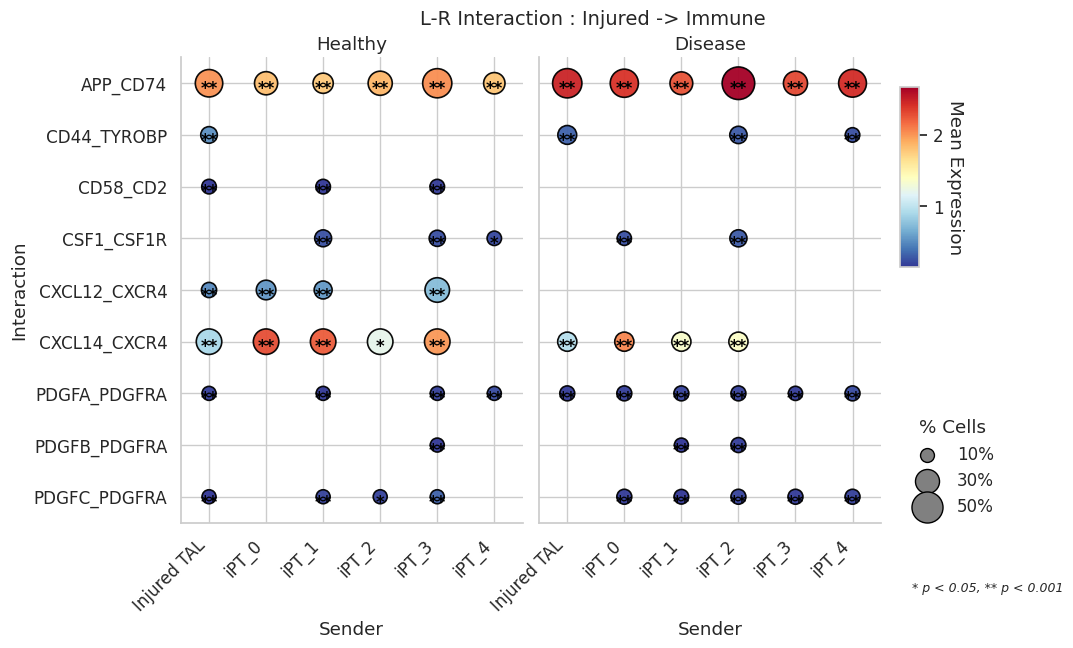

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import numpy as np
import os

# 1. Configuration
# Input Data Path
CSV_PATH = "../../analysis/06_CellPhoneDB_Hotspots_Direct/cellphonedb_results/Comparison_Healthy_vs_Disease_PlotData.csv"
# Output Directory
OUTPUT_DIR = "../../analysis/06_CellPhoneDB_Hotspots_Direct/"

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 2. Load Data
if os.path.exists(CSV_PATH):
    print(f"Loading data from {CSV_PATH}...")
    df = pd.read_csv(CSV_PATH)
else:
    raise FileNotFoundError(f"Expected data file not found at: {CSV_PATH}")

# 3. Process Data
if 'Sender' not in df.columns:
    df['Sender'] = df['Cell_Pair'].apply(lambda x: x.split(' -> ')[0])

# Map Categorical Strings to Numbers
sender_order = sorted(df['Sender'].unique())
sender_map = {k: v for v, k in enumerate(sender_order)}

interaction_order = sorted(df['Interaction'].unique(), reverse=True)
interaction_map = {k: v for v, k in enumerate(interaction_order)}

# Create numeric columns for plotting
df['Sender_Idx'] = df['Sender'].map(sender_map)
df['Interaction_Idx'] = df['Interaction'].map(interaction_map)

# 4. Plotting
sns.set(style="whitegrid", font_scale=1.1)

# Create grid
g = sns.FacetGrid(
    df,
    col="Condition",
    col_order=["Healthy", "Disease"],
    height=6,
    aspect=0.8,
    sharey=True
)


def scatter_plot(x, y, mean_val, pct_val, p_val, **kwargs):
    ax = plt.gca()

    # Scatter plot
    points = ax.scatter(
        x=x,
        y=y,
        c=mean_val,
        s=pct_val*10,
        # "RdYlBu_r" is widely used in single-cell papers (Red=High, Yellow=Mid, Blue=Low)
        cmap="RdYlBu_r",
        vmin=df['Mean'].min(),
        vmax=df['Mean'].max(),
        edgecolor='black',
        linewidth=1.2,
        alpha=0.95
    )

    # Add Stars for Significance
    for x_i, y_i, p_i in zip(x, y, p_val):
        star = ""
        if p_i < 0.001:
            star = "**"
        elif p_i < 0.05:
            star = "*"

        if star:
            # Center the star inside the dot
            # Subtract 0.1 from y to visually center the text
            ax.text(x_i, y_i-0.1, star, ha='center', va='center',
                    color='black', fontweight='bold', fontsize=12)

    return points


# Map the plot using NUMERIC indices
g.map(
    scatter_plot,
    "Sender_Idx",
    "Interaction_Idx",
    "Mean",
    "Pct",
    "P-value"
)

# 5. Add Aesthetics & Restore Labels
g.set_titles("{col_name}")

# Restore string labels
g.set(
    xticks=list(sender_map.values()),
    xticklabels=list(sender_map.keys()),
    yticks=list(interaction_map.values()),
    yticklabels=list(interaction_map.keys())
)

# Explicitly set axis labels to remove "Idx"
g.set_axis_labels("Sender", "Interaction")

for ax in g.axes.flat:
    # Set limits to include margins
    ax.set_xlim(-0.5, len(sender_order) - 0.5)
    ax.set_ylim(-0.5, len(interaction_order) - 0.5)

    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha('right')

# --- CUSTOM LEGEND LAYOUT ---
plt.subplots_adjust(top=0.9, right=0.8)

# 1. Colorbar (Mean Expression) - TOP HALF
pos = g.axes.flat[-1].get_position()
cax = g.fig.add_axes([0.82, 0.55, 0.02, 0.3])

norm = plt.Normalize(df['Mean'].min(), df['Mean'].max())
sm = plt.cm.ScalarMappable(cmap="RdYlBu_r", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("Mean Expression", rotation=270, labelpad=15)

# 2. Size Legend (% Cells) - BOTTOM HALF
sizes = [10, 30, 50]
legend_markers = [plt.scatter(
    [], [], s=s*10, c='gray', edgecolors='black') for s in sizes]

g.axes.flat[-1].legend(
    legend_markers,
    [f"{s}%" for s in sizes],
    title="% Cells",
    bbox_to_anchor=(1.35, 0.0),
    loc='lower right',
    borderaxespad=0,
    frameon=False
)

g.fig.suptitle(
    "L-R Interaction : Injured -> Immune", fontsize=14, y=0.98)
plt.figtext(0.99, 0.01, "* p < 0.05, ** p < 0.001",
            ha="right", fontsize=9, style='italic')

# Save PNG and PDF to the specified output directory
png_filename = os.path.join(OUTPUT_DIR, "Comparison_DotPlot.png")
pdf_filename = os.path.join(OUTPUT_DIR, "Comparison_DotPlot.pdf")

plt.savefig(png_filename, bbox_inches='tight', dpi=300)
plt.savefig(pdf_filename, bbox_inches='tight')

print(f"Plots saved to:\n  - {png_filename}\n  - {pdf_filename}")
plt.show()
